# Get Data From API and save it for further use

In [1]:
# !pip install pandas_datareader

In [2]:
import warnings
import pandas_datareader as pdr

# Configure warning filters
warnings.filterwarnings("ignore")

In [3]:
# Get data from Tiingo
data = pdr.get_data_tiingo('AAPL', api_key='1b82b56833e3ecdfdf8e30e1353779aa39683e99')

# save .csv file
data.to_csv('data.csv')

# Processing Data

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt

In [5]:
plt.rcParams['font.size']=10

In [6]:
df = pd.read_csv('data.csv', index_col= False)
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2018-09-04 00:00:00+00:00,228.36,229.18,226.63,228.41,27390132,54.673002,54.869323,54.258813,54.684973,109560528,0.0,1.0
1,AAPL,2018-09-05 00:00:00+00:00,226.87,229.67,225.10,228.99,33332960,54.316273,54.986637,53.892507,54.823834,133331840,0.0,1.0
2,AAPL,2018-09-06 00:00:00+00:00,223.10,227.35,221.30,226.23,34289976,53.413675,54.431192,52.982726,54.163047,137159904,0.0,1.0
3,AAPL,2018-09-07 00:00:00+00:00,221.30,225.37,220.71,221.85,37619810,52.982726,53.957149,52.841471,53.114405,150479240,0.0,1.0
4,AAPL,2018-09-10 00:00:00+00:00,218.33,221.85,216.47,220.95,39516453,52.271661,53.114405,51.826348,52.898931,158065812,0.0,1.0


In [7]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

### Initial Data Plot

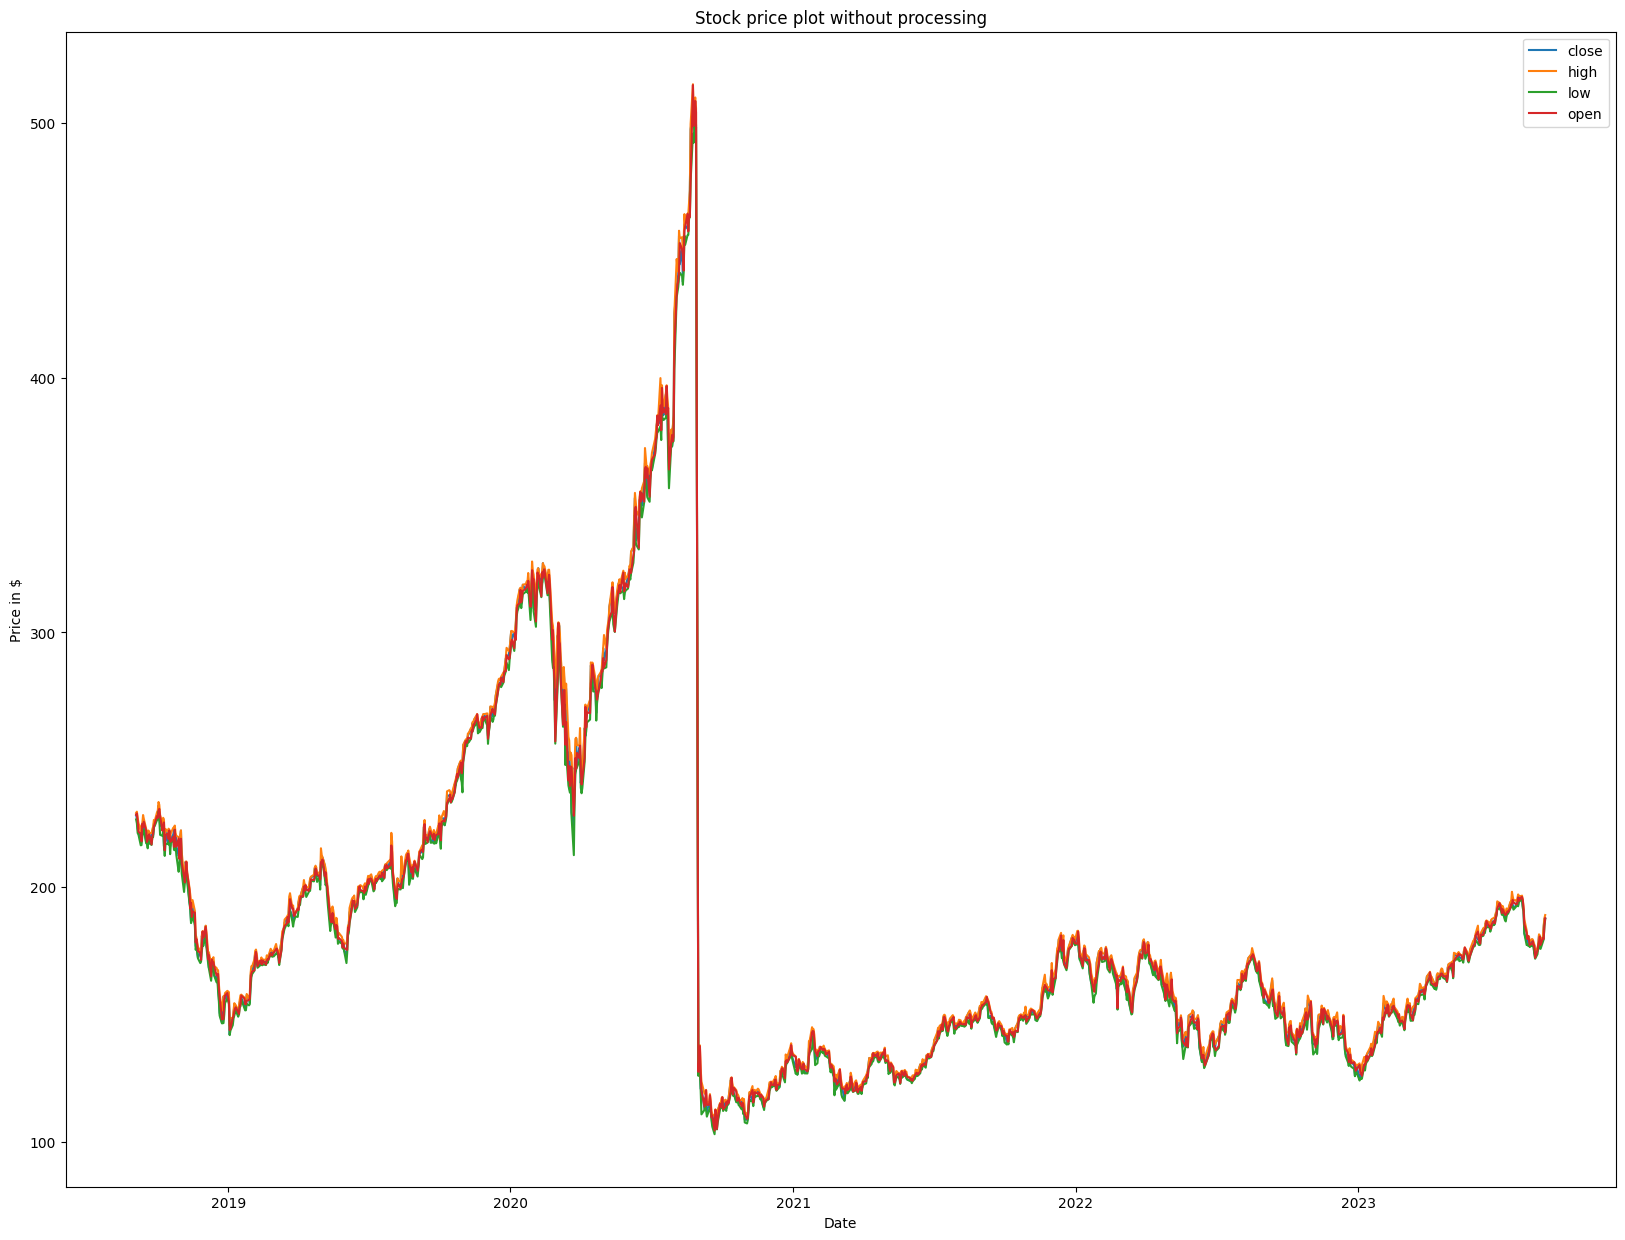

In [8]:
plt.figure(figsize=(20, 15))
plt.title("Stock price plot without processing")
plt.ylabel("Price in $")
plt.xlabel("Date")
plt.plot(df['date'], df[["close", "high", "low", "open"]], label=['close', 'high', 'low', 'open'])
plt.legend()
plt.show()

In [9]:
split_index = df[df['splitFactor'] != 1.0].index[0]
print("Index for split point", split_index)
df[df['splitFactor'] != 1.0]

Index for split point 501


,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
501,AAPL,2020-08-31 00:00:00+00:00,129.04,131.0,126.0,127.58,223505733,126.748547,128.673742,123.76253,125.314473,223505733,0.0,4.0


In [10]:
cost = df[['close', 'high', 'low', 'open']]
cost = np.array(cost)
cost

array([[228.36 , 229.18 , 226.63 , 228.41 ],
       [226.87 , 229.67 , 225.1  , 228.99 ],
       [223.1  , 227.35 , 221.3  , 226.23 ],
       ...,
       [184.12 , 184.9  , 179.5  , 179.695],
       [187.65 , 187.85 , 184.74 , 184.94 ],
       [187.87 , 189.12 , 187.48 , 187.84 ]])

In [11]:
print("split index: ", split_index)

split index:  501


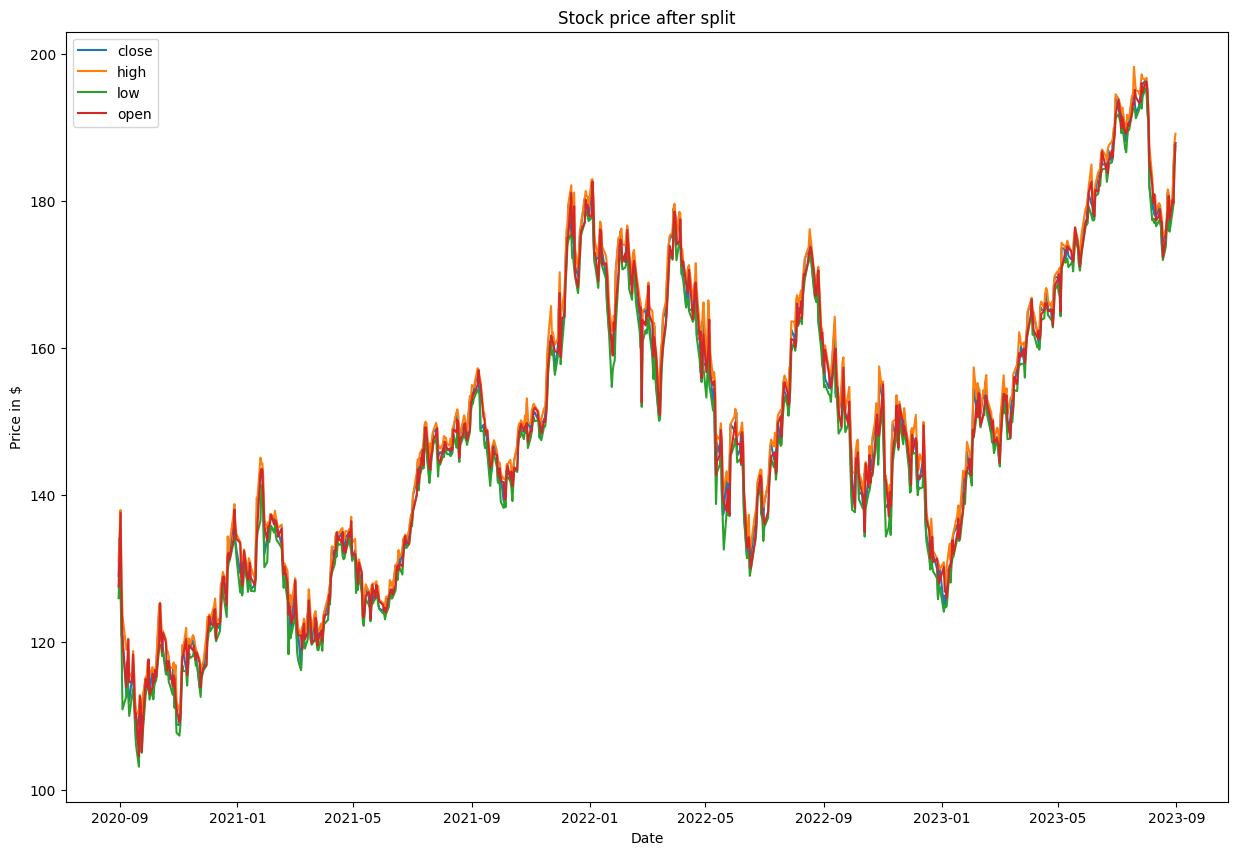

In [12]:
# before split graph
plt.figure(figsize=(15, 10))
plt.title("Stock price after split")
plt.ylabel("Price in $")
plt.xlabel("Date")
plt.plot(df["date"][split_index:], cost[split_index:])
plt.legend(['close', 'high', 'low', 'open'])
plt.show()

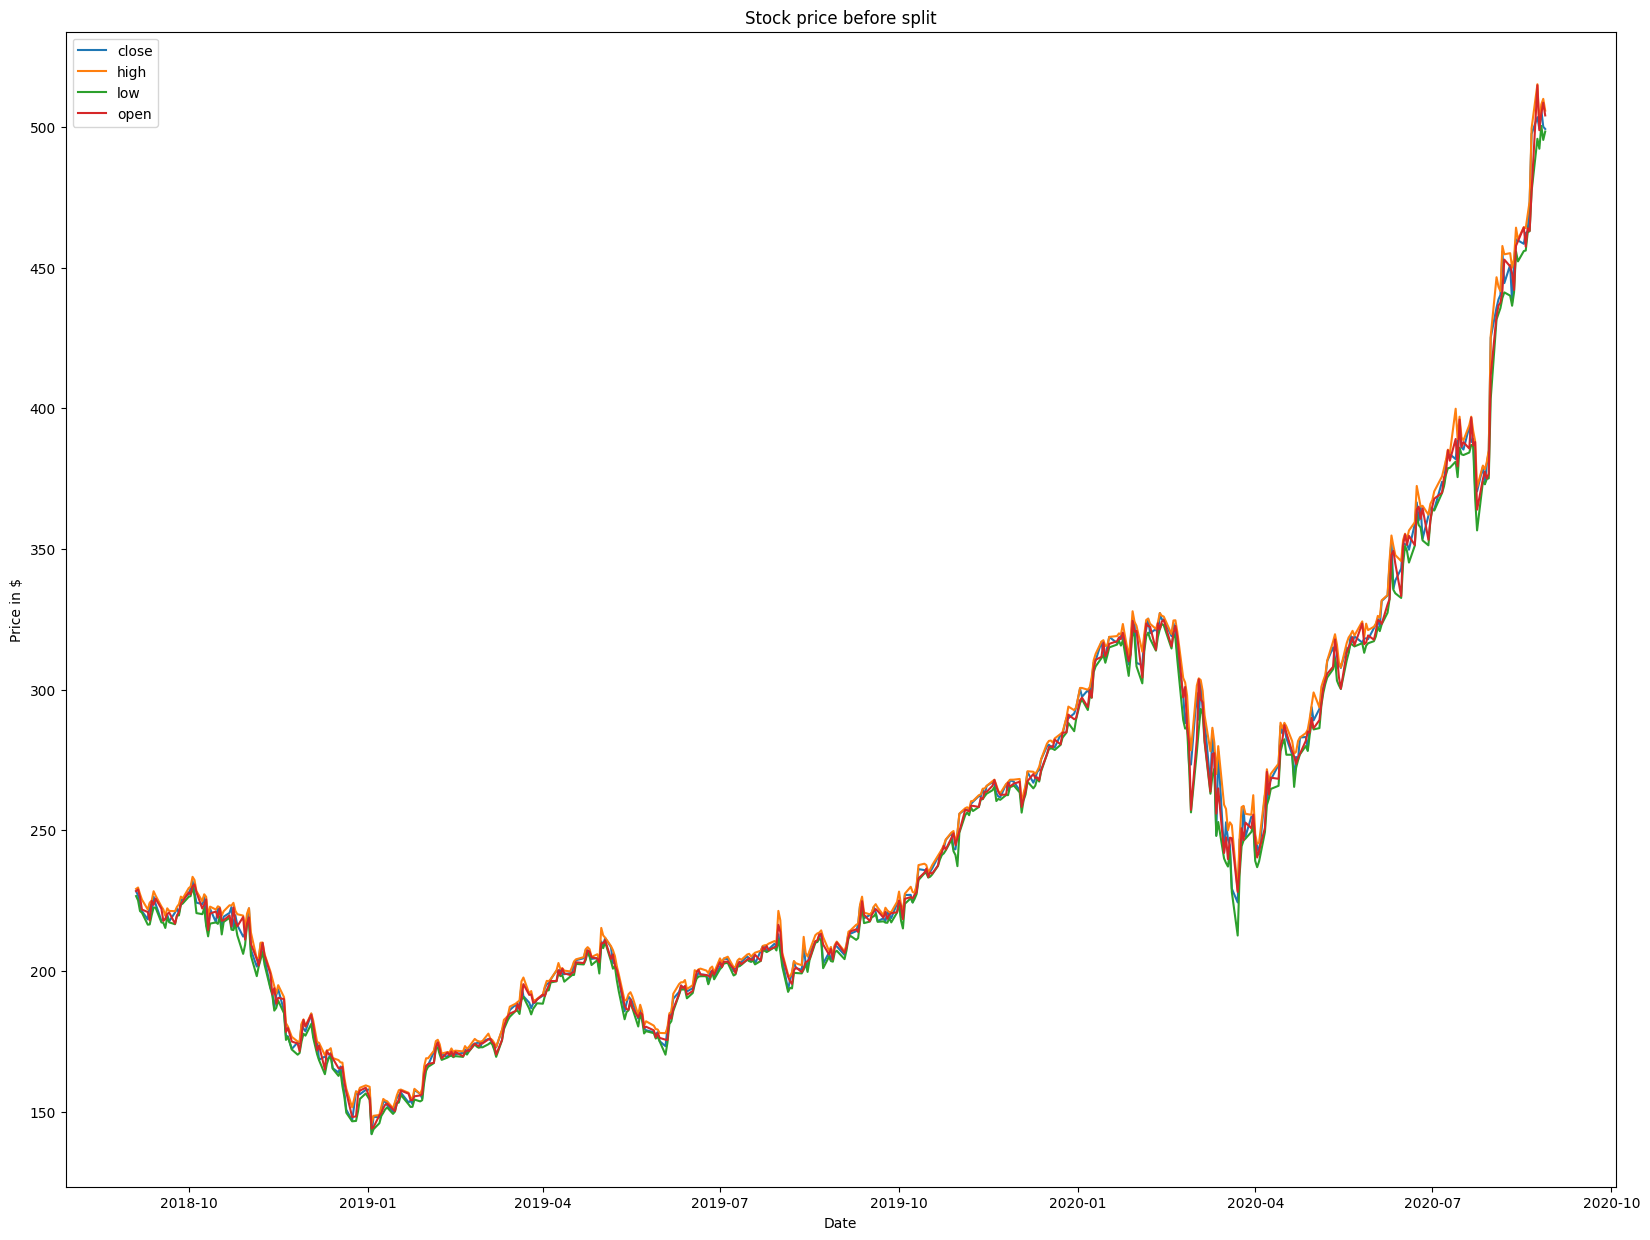

In [13]:
# After split graph
plt.figure(figsize=(20, 15))
plt.title("Stock price before split")
plt.ylabel("Price in $")
plt.xlabel("Date")
plt.plot(df["date"][:split_index], cost[:split_index])
plt.legend(['close', 'high', 'low', 'open'])
plt.show()

# 4:1 split of share
Divide share price by 4 before split

In [14]:
before_split = (cost[:split_index] / 4).round(2)
after_split = cost[split_index:]
time_series_data = np.concatenate((before_split, after_split), axis=0)

In [15]:
series_dataframe = pd.DataFrame(time_series_data, columns=['close', 'high', 'low', 'open'])
series_dataframe.head()

,close,high,low,open
0,57.09,57.30,56.66,57.10
1,56.72,57.42,56.28,57.25
2,55.78,56.84,55.32,56.56
3,55.32,56.34,55.18,55.46
4,54.58,55.46,54.12,55.24


<Axes: title={'center': 'Stock Price after preprocessing'}, xlabel='Index', ylabel='Price of Stock in $'>

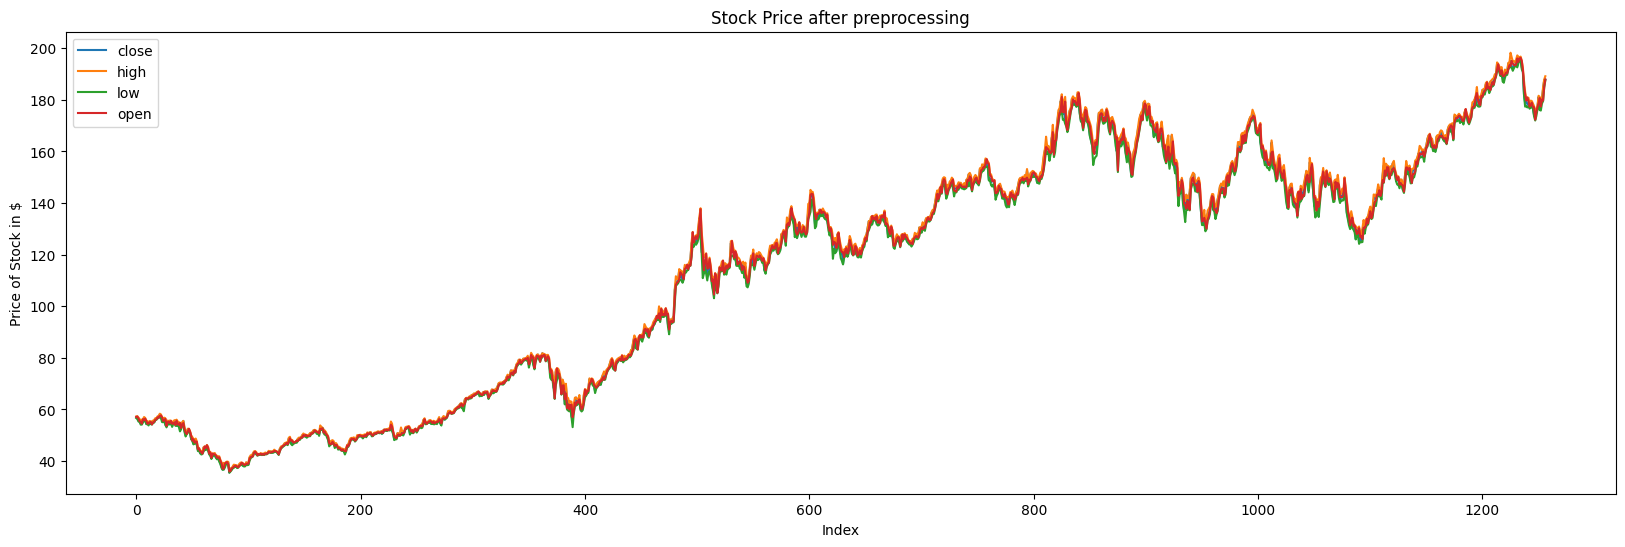

In [16]:
assert cost.shape == series_dataframe.shape

series_dataframe.plot(figsize=(20,6),
                      title='Stock Price after preprocessing',
                      xlabel='Index', ylabel='Price of Stock in $')

In [17]:
print("After preprocessing")
print(f"Maximum stock price: {np.max(time_series_data)}")
print(f"Minimum Stock price: {np.min(time_series_data)}")

After preprocessing
Maximum stock price: 198.23
Minimum Stock price: 35.5


### Only use one column of data [close price]

In [18]:
series_dataframe = series_dataframe.close

<Axes: title={'center': 'Stock Price after preprocessing'}, xlabel='Index', ylabel='Log Price of Stock in $'>

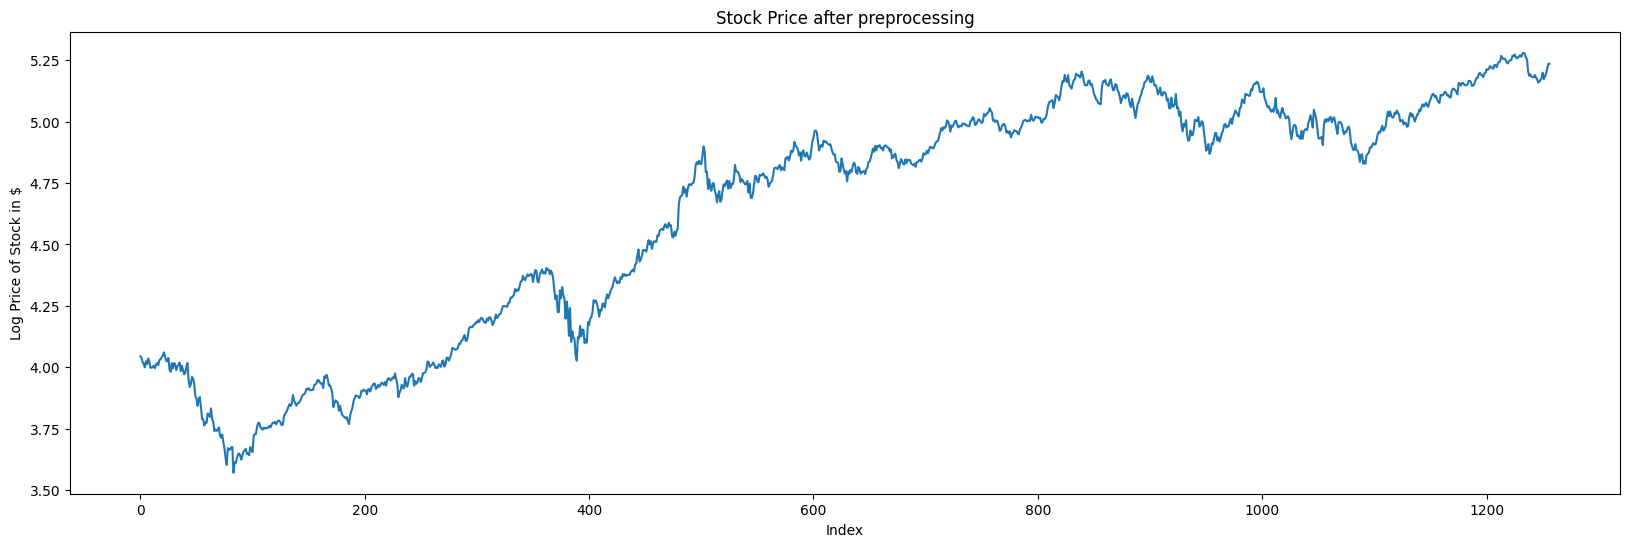

In [19]:
series_df_log = np.log(series_dataframe)
series_df_log.plot(figsize=(20,6),
                      title='Stock Price after preprocessing',
                      xlabel='Index', ylabel='Log Price of Stock in $')

### Smoothing

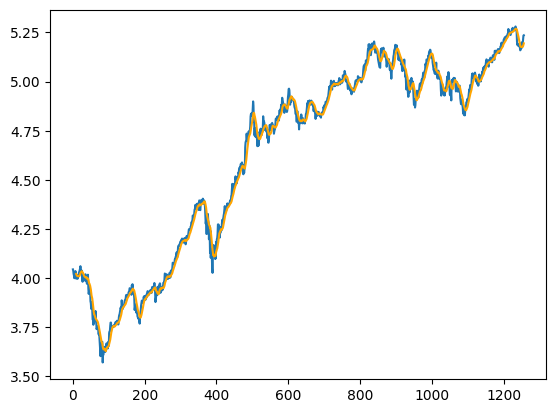

In [20]:
moving_avg = series_df_log.rolling(10).mean()
plt.plot(series_df_log)
plt.plot(moving_avg, color="orange")

## **Prepare Dataset**

In [21]:
df_train, df_val = train_test_split(series_dataframe, test_size=0.2, shuffle=False)
print(f"Shape of training df: {df_train.shape}")
print(f"Shape of val df: {df_val.shape}")

Shape of training df: (1005,)
Shape of val df: (252,)


<Axes: title={'center': 'Train data plot'}, xlabel='Index', ylabel='Price of Stock in $'>

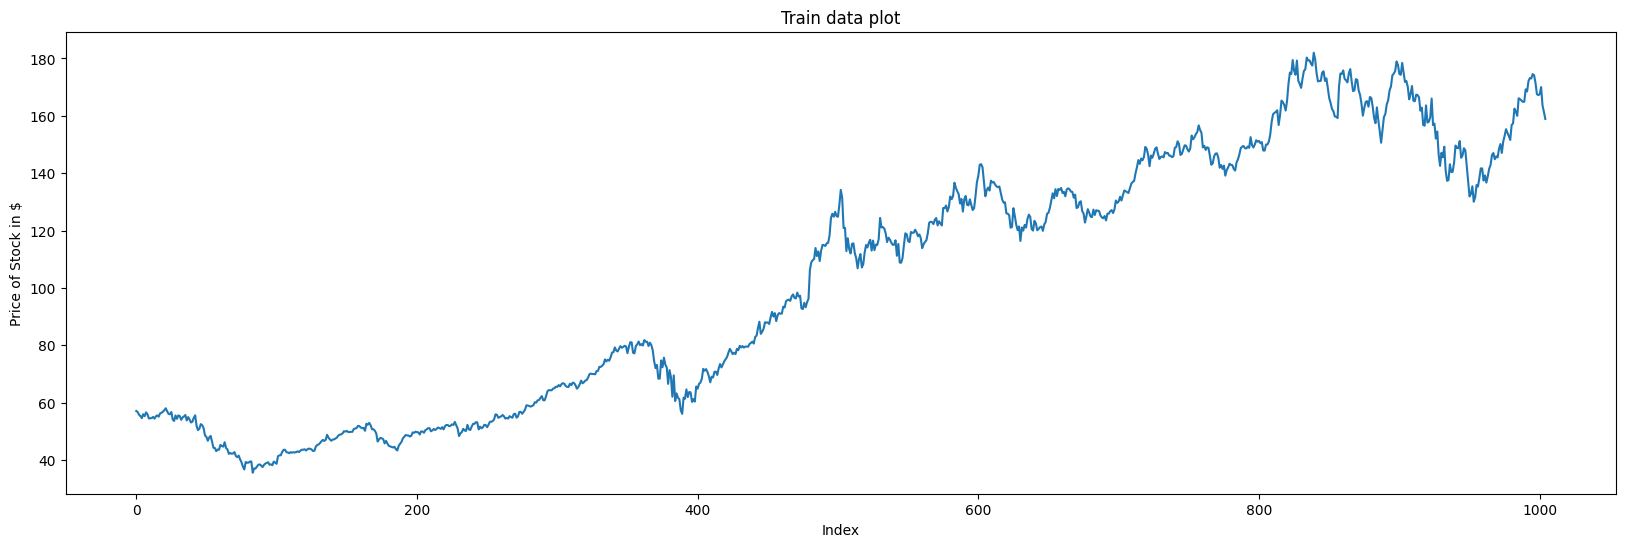

In [22]:
# plot of train data
df_train.plot(figsize=(20,6),
                      title='Train data plot',
                      xlabel='Index', ylabel='Price of Stock in $')

<Axes: title={'center': 'Validation data plot'}, xlabel='Index', ylabel='Price of Stock in $'>

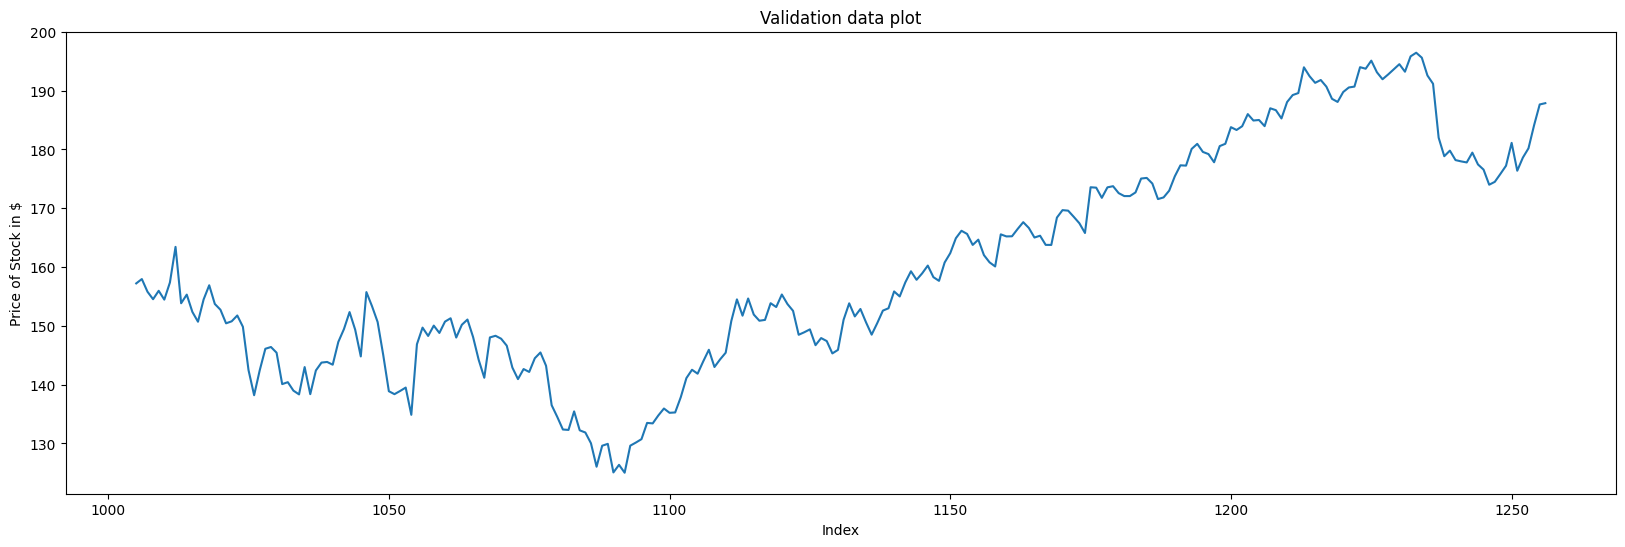

In [23]:
# plot of val data
df_val.plot(figsize=(20,6),
                      title='Validation data plot',
                      xlabel='Index', ylabel='Price of Stock in $')

In [24]:
# number of steps in input to predict upcoming price
N_STEPS = 3
N_TARGET = 1

In [25]:
def prepare_dataset(time_series, n_steps, n_target=None):
  if (n_target < 0 and n_target > 4) or n_target is None:
    print(f"[WARN]: n_target should be between 1 to 4")
    n_target = 4
  seq_x, seq_y = [], []
  print(time_series.shape)
  for id_x in range(len(time_series)-n_steps-1):
    # print(id_x)
    endx = id_x + n_steps

    x = time_series[id_x:endx].tolist()
    try:
      y = time_series[endx][:n_target]
    except:
      y = time_series[endx]

    # print(y)
    seq_x.append(x)
    seq_y.append(y)
  return np.array(seq_x), np.array(seq_y)

In [26]:
X_train, y_train = prepare_dataset(np.array(df_train), n_steps=N_STEPS, n_target=N_TARGET)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

(1005,)
Shape of X_train: (1001, 3)
Shape of y_train: (1001,)


In [27]:
X_val, y_val = prepare_dataset(np.array(df_val), n_steps=N_STEPS, n_target=N_TARGET)
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

(252,)
Shape of X_val: (248, 3)
Shape of y_val: (248,)


In [28]:
# reshape X_train to 3 dimension [samples, timesteps, n_features]
if X_train.ndim == 2:
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

  print(f"Shape of X_train: {X_train.shape}")

Shape of X_train: (1001, 3, 1)


### **Model Training**

In [29]:
model = tf.keras.models.Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True,
               input_shape=(N_STEPS, N_TARGET)))
model.add(LSTM(16, activation='relu'))

# Dense layers for regression
model.add(Dense(1, name="output-layer"))


model.compile(optimizer='adam', loss='mse')
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 16)                4288      
                                                                 
 output-layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 14,705
Trainable params: 14,705
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(X_train, y_train,
                    validation_data=[X_val, y_val],
                    epochs=15)

Epoch 1/15
32/32 [==============================] - 7s 64ms/step - loss: 9342.8936 - val_loss: 5038.6387
Epoch 2/15
32/32 [==============================] - 1s 20ms/step - loss: 336.2363 - val_loss: 110.2636
Epoch 3/15
32/32 [==============================] - 1s 22ms/step - loss: 16.2086 - val_loss: 23.0918
Epoch 4/15
32/32 [==============================] - 0s 15ms/step - loss: 10.5099 - val_loss: 17.1310
Epoch 5/15
32/32 [==============================] - 0s 12ms/step - loss: 9.8965 - val_loss: 15.6995
Epoch 6/15
32/32 [==============================] - 0s 14ms/step - loss: 9.6118 - val_loss: 15.1763
Epoch 7/15
32/32 [==============================] - 0s 13ms/step - loss: 9.4688 - val_loss: 17.7119
Epoch 8/15
32/32 [==============================] - 0s 15ms/step - loss: 9.1947 - val_loss: 15.8227
Epoch 9/15
32/32 [==============================] - 0s 13ms/step - loss: 9.6162 - val_loss: 14.0077
Epoch 10/15
32/32 [==============================] - 0s 13ms/step - loss: 8.9414 - val_los

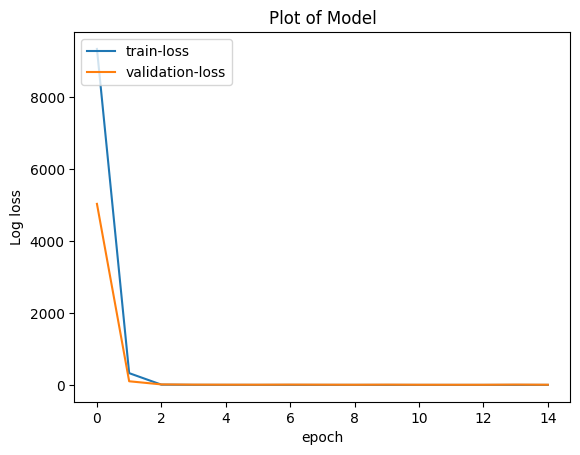

In [31]:
def plot_history(history):
  #loss plot
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Plot of Model')
  plt.ylabel('Log loss')
  plt.xlabel('epoch')
  plt.legend(['train-loss', 'validation-loss'], loc='upper left')
  plt.show()

plot_history(history)

## Predictation

---



In [32]:
LAST_KNOWN_STOCKS = N_STEPS * 8
input_series = np.array(series_dataframe[-LAST_KNOWN_STOCKS:])
x_input = input_series[:N_STEPS]
temp_series = list(x_input)

print(x_input.shape)
x_input = x_input.reshape(x_input.shape[0] // N_STEPS, N_STEPS, 1)
print("Reshape input fed: ", x_input.shape)

(3,)
Reshape input fed:  (1, 3, 1)


In [33]:
y_hat = model.predict(x_input)
print(f"Shape of y_hat: {y_hat} and value: {y_hat}")

1/1 [==============================] - 1s 721ms/step
Shape of y_hat: [[193.1235]] and value: [[193.1235]]


In [34]:
i = 0
FUTURE_PREDICT_DAY = LAST_KNOWN_STOCKS
next_series = list()
while i < FUTURE_PREDICT_DAY:
  y_hat = model.predict(x_input.tolist(), verbose=0)
  next_series.append(y_hat[0][0])
  temp_series.append(y_hat[0][0])
  try:
    x_input = np.array(temp_series[-N_STEPS:])
    x_input = x_input.reshape(1, N_STEPS, 1)
  except Exception as err:
    print(err)
  i += 1


In [35]:
index = np.arange(1, len(input_series) + 1)
index.shape, len(next_series)

((24,), 24)

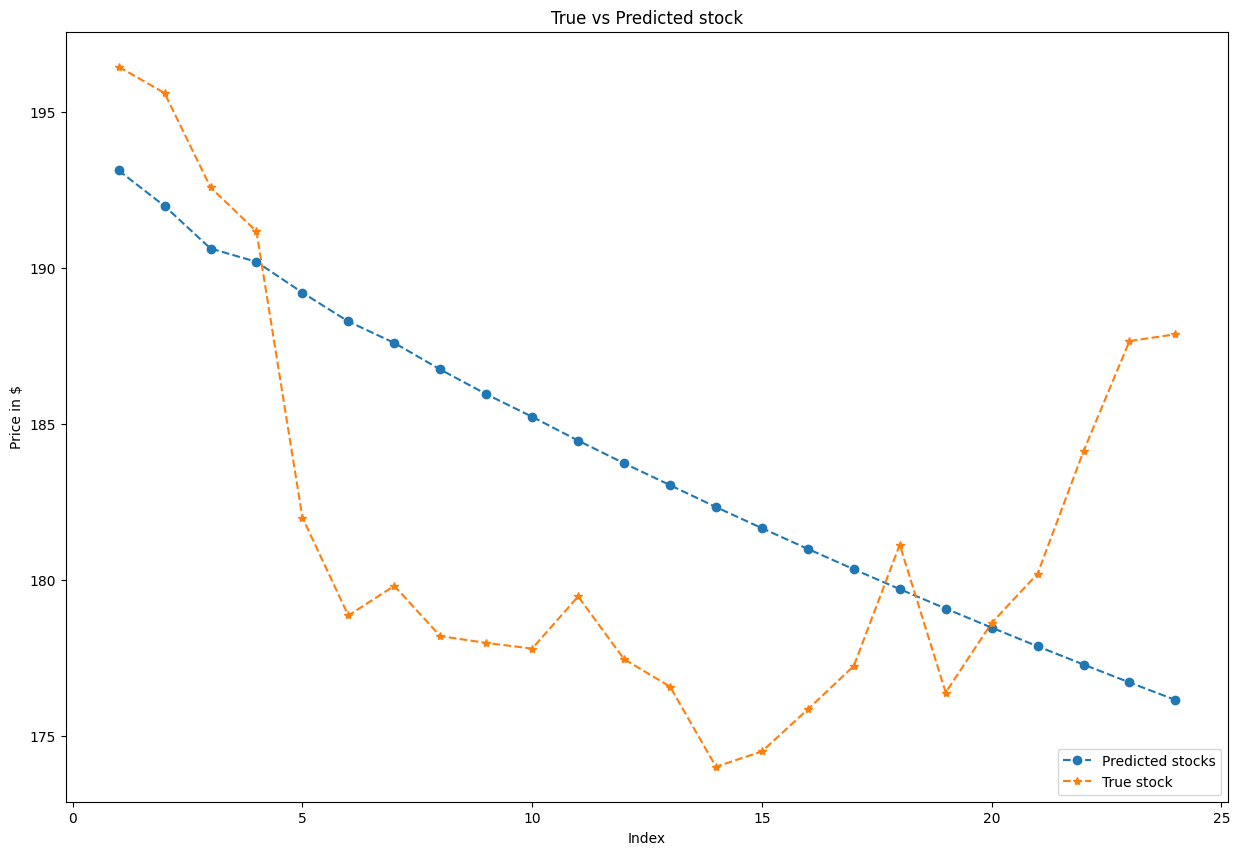

In [36]:
# plot true value vs predicted series
plt.figure(figsize=(15, 10))
plt.plot(index, next_series, 'o--', label="Predicted stocks")
plt.plot(index, input_series, '*--', label="True stock")
plt.xlabel("Index")
plt.ylabel("Price in $")
plt.title("True vs Predicted stock")
plt.legend(loc='lower right')
plt.show()